In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import skew, kurtosis, shapiro
plt.style.use(['bmh'])
import talib
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
import yaml

In [10]:
all_config = yaml.safe_load(open("../config/config_file.yml", "r"))

In [7]:
df_input = pd.read_csv('../src/data/example_data.csv')

In [11]:
all_config

{'model': {'kpis': ['rsi', {'sma': [12, 24]}, {'bbands': [1, 1, 20]}],
  'method': 'max_sharpe'},
 'output': {'data_folder': './data', 'log_folder': './data/logs'},
 'stocks': {'data': 'example_data.csv',
  'end': None,
  'metric': 'Adj Close',
  'source': 'yahoo',
  'start': 30}}

In [599]:
ticks = df_input['TICK'].to_list()
if df_input['WEIGHT'].isna().sum():
    print("Please check weights because there are missing values. Equals weight be stocks will be asigned")
    n_stocks = df_input.shape[0]
    weights = np.repeat(1/n_stocks, n_stocks)
else:
    weights = df_input['WEIGHT'].to_list()

In [600]:
mask = df_input['WEIGHT'].isna() == True

In [601]:
#ticks = ['UNH', 'MSFT', 'AAPL', 'GOOGL', 'V', 'PYPL', 'AMZN', 'PYPL']
#tick_sp500 = ['^GSPC']

end_date = dt.date.today()
start_date = end_date - dt.timedelta(360)
today = dt.datetime.today().strftime("%Y-%m-%d")
n_stocks = len(ticks)
weights = np.repeat(1/n_stocks, n_stocks)

In [602]:
def get_stock_data(stocks, start_date, today, col='Adj Close', source='yahoo'):
    df = pdr.get_data_yahoo(stocks, start=start_date, end=end_date)[col]
    return df

In [603]:
df = get_stock_data(ticks, start_date, end_date)
#sp500 = get_stock_data(tick_sp500, start_date, end_date)

[*********************100%***********************]  30 of 30 completed


In [604]:
df.tail()

,AAPL,ACN,AXP,BA,BABA,BRK-B,CSCO,DIS,EGP,FB,...,NFLX,NKE,NVDA,PEP,PG,SBUX,SUI,TMUS,UNH,V
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-31,151.830002,336.559998,165.960007,219.500000,166.990005,285.769989,59.020000,181.300003,180.259995,379.380005,...,569.190002,164.740005,223.850006,155.325348,142.389999,117.489998,201.490005,137.020004,416.269989,229.100006
2021-09-01,152.509995,337.899994,164.440002,218.119995,173.279999,285.260010,59.040001,183.479996,182.500000,382.049988,...,582.070007,164.559998,224.410004,156.835007,143.839996,117.449997,206.250000,137.740005,417.350006,230.119995
2021-09-02,153.649994,341.000000,162.050003,220.830002,172.000000,285.049988,59.529999,181.860001,183.800003,375.279999,...,588.549988,163.669998,223.960007,156.949997,143.949997,117.370003,209.330002,136.130005,423.709991,224.179993
2021-09-03,154.300003,343.329987,159.300003,218.169998,170.300003,281.890015,59.419998,181.000000,184.520004,376.260010,...,590.530029,163.289993,228.429993,157.089996,144.050003,117.190002,209.130005,136.000000,422.859985,225.110001
2021-09-07,156.690002,341.489990,159.720001,214.240005,175.160004,278.899994,58.880001,184.339996,181.589996,382.179993,...,606.710022,162.639999,226.619995,154.529999,143.509995,115.790001,206.399994,134.470001,421.239990,226.270004


In [605]:
tk = 'AAPL'

In [606]:
df_clean = pd.DataFrame(columns=['price','stock','rsi','ema_12','ema_26','bb_low','bb_mid','bb_up'])
for col in df.columns.to_list():
# df.columns.to_list():
    df_aux = pd.DataFrame()
    df_aux = df[[col]]
    df_aux.columns = ['price']
    df_aux['stock'] = col
    df_aux['rsi'] = talib.RSI(df.loc[:, col])
    df_aux['ema_12'] = talib.EMA(df.loc[:, col], 12)
    df_aux['ema_26'] = talib.EMA(df.loc[:, col], 26)
    upper_1sd, mid_1sd, lower_1sd = talib.BBANDS(df.loc[:, col], nbdevup=1, nbdevdn=1, timeperiod=20)
    df_aux['bb_low'] = upper_1sd
    df_aux['bb_mid'] = mid_1sd
    df_aux['bb_up'] = lower_1sd
    df_clean = df_clean.append(df_aux)

/mnt/c/Users/34660/Documents/projects/stocks/stocks-invesment/.venv_dev/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/mnt/c/Users/34660/Documents/projects/stocks/stocks-invesment/.venv_dev/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/mnt/c/Users/34660/Documents/projects/stocks/stocks-invesment/.venv_dev/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [607]:
df_clean['rsi_f'] = np.where(df_clean['rsi']<=40,1,0)
df_clean['bb_f'] = np.where(df_clean['price'] < df_clean['bb_low'], 1, 0)
df_clean['ema_f'] = np.where(df_clean['ema_12']>= df_clean['ema_26'], 1, 0)
df_clean['score'] = df_clean['ema_f'] + df_clean['rsi_f'] + df_clean['bb_f']

In [608]:
df_clean.tail()

,price,stock,rsi,ema_12,ema_26,bb_low,bb_mid,bb_up,rsi_f,bb_f,ema_f,score
2021-08-31,229.100006,V,37.830446,232.584925,234.926470,237.394109,234.143068,230.892027,1,1,0,2
2021-09-01,230.119995,V,40.331671,232.205705,234.570434,237.154103,233.831677,230.509251,0,1,0,1
2021-09-02,224.179993,V,32.205577,230.970980,233.800772,236.686428,233.046527,229.406626,1,1,0,2
2021-09-03,225.110001,V,34.433015,230.069291,233.157011,235.789855,232.248459,228.707062,1,1,0,2
2021-09-07,226.270004,V,37.204408,229.484785,232.646863,234.913422,231.578295,228.243169,1,1,0,2


In [610]:
df_clean[(df_clean['score']>=2) & (df_clean.index=='2021-09-01')] 

,price,stock,rsi,ema_12,ema_26,bb_low,bb_mid,bb_up,rsi_f,bb_f,ema_f,score
2021-09-01,285.260010,BRK-B,51.249476,285.902264,284.882066,289.051337,286.711499,284.371661,0,1,1,2
2021-09-01,159.720001,JPM,55.698626,159.221638,157.656818,161.218938,158.544498,155.870059,0,1,1,2
2021-09-01,349.570007,MA,36.508087,356.015699,362.216410,367.832549,360.666501,353.500453,1,1,0,2
2021-09-01,238.149994,MCD,54.193351,236.909810,236.586080,238.188658,236.357080,234.525502,0,1,1,2
2021-09-01,301.829987,MSFT,65.355817,299.384560,294.049937,302.134917,295.665048,289.195179,0,1,1,2
2021-09-01,164.559998,NKE,44.541237,167.432864,166.697951,171.893458,169.318954,166.744449,0,1,1,2
2021-09-01,143.839996,PG,58.065703,143.118894,142.301759,144.276841,143.227999,142.179158,0,1,1,2
2021-09-01,137.740005,TMUS,35.904516,139.540971,141.240678,143.513290,141.103500,138.693709,1,1,0,2
2021-09-01,417.350006,UNH,50.521423,418.600204,417.049797,423.400078,417.113998,410.827919,0,1,1,2


In [593]:
df_clean.tail()

,price,stock,rsi,ema_12,ema_26,bb_low,bb_mid,bb_up,rsi_f,bb_f,ema_f,score
2021-08-26,230.520004,V,38.575977,233.741938,235.968441,239.539874,235.605836,231.671798,1,1,0,2
2021-08-27,232.690002,V,43.634785,233.580102,235.725594,238.099321,234.937608,231.775894,0,1,0,1
2021-08-30,231.229996,V,41.177529,233.218547,235.392587,237.607823,234.526429,231.445035,0,1,0,1
2021-08-31,229.100006,V,37.830447,232.584925,234.926470,237.394109,234.143068,230.892027,1,1,0,2
2021-09-01,230.119995,V,40.331671,232.205705,234.570434,237.154103,233.831677,230.509251,0,1,0,1


In [492]:
df_test = df['AAPL']

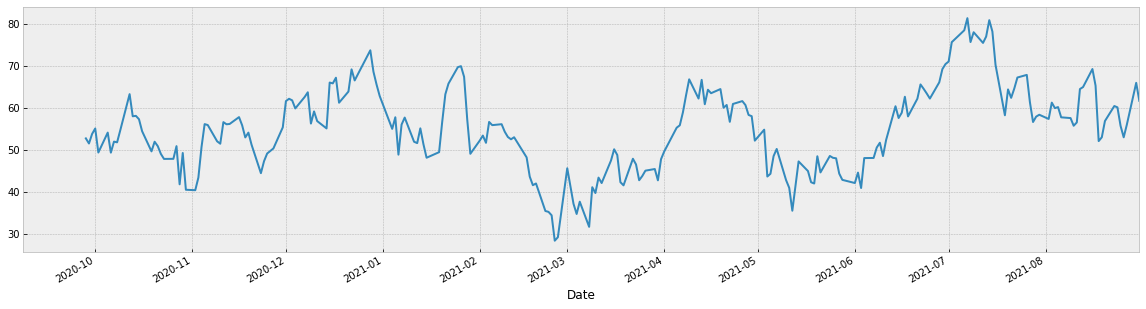

In [533]:
talib.RSI(df[tk]).plot(figsize=(20,5))

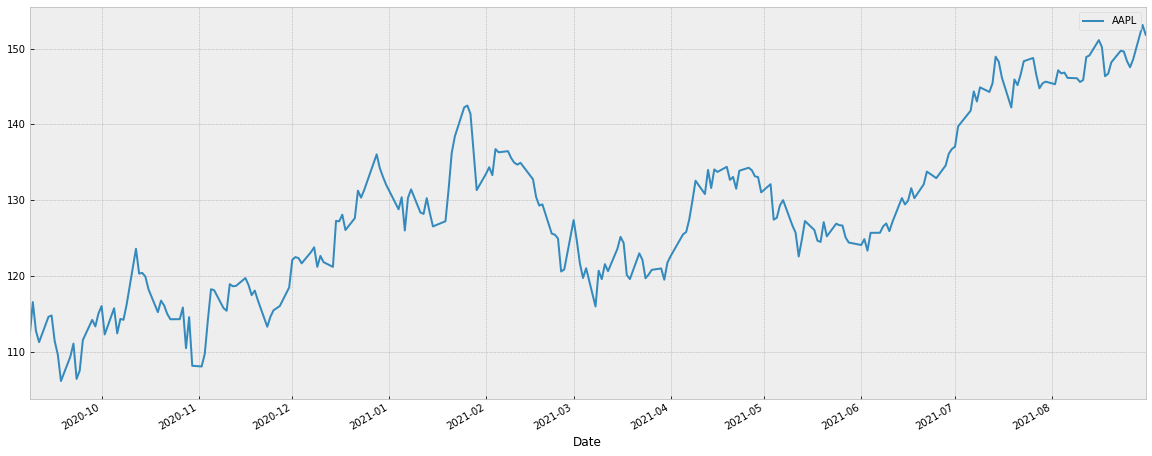

In [534]:
df[[tk]].plot(figsize=(20,8))

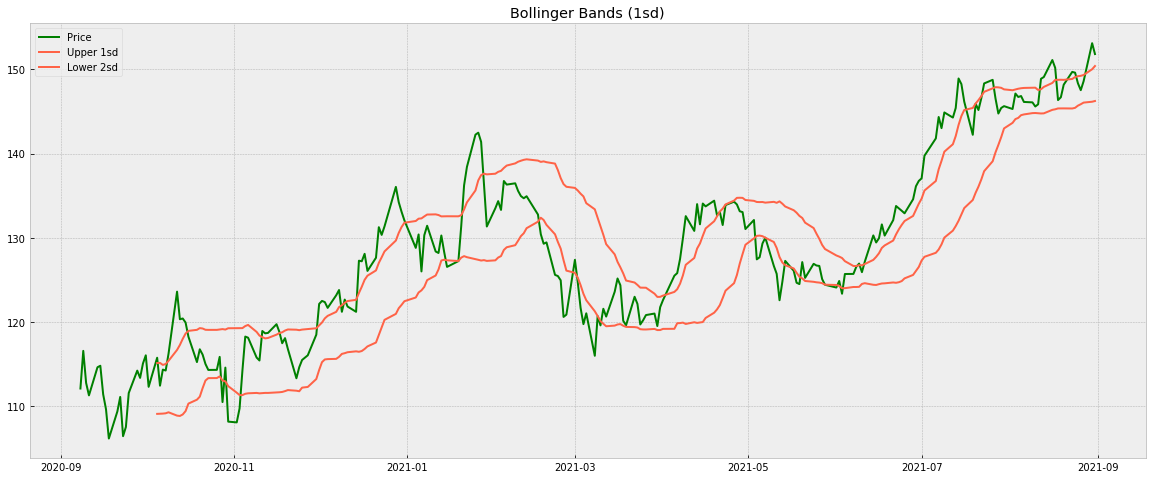

In [535]:
upper_1sd, mid_1sd, lower_1sd = talib.BBANDS(df[tk], 
                                     nbdevup=1,
                                     nbdevdn=1,
                                     timeperiod=20)
# Plot the upper and lower Bollinger Bands 
plt.figure(figsize=(20,8))
plt.plot(df[tk], color='green', label='Price')
plt.plot(upper_1sd, color='tomato', label="Upper 1sd")
plt.plot(lower_1sd, color='tomato', label='Lower 2sd')

# Customize and show the plot
plt.legend(loc='upper left')
plt.title('Bollinger Bands (1sd)')
plt.show()


In [158]:
df_new = pd.DataFrame(index = df.index)

In [40]:
df_aux = pd.DataFrame(columns=['tick', 'value', 'sma_30', 'sma_60'])

In [41]:
df_aux.head()

,tick,value,sma_30,sma_60


In [42]:
df_aux = pd.DataFrame(columns=['tick', 'value', 'sma_20', 'sma_50', 'sma_flag'])
for col in df.columns:
    df_new = pd.DataFrame(index = df.index)
    df_new['tick'] = col
    df_new['value'] = df[col]
    df_new['sma_20'] = df_new['value'].rolling(20).mean()
    df_new['sma_50'] = df_new['value'].rolling(50).mean()
    df_new['sma_flag'] = np.where(df_new['sma_20'] <= df_new['sma_50'], 1, 0)
    df_aux = pd.concat([df_aux, df_new], axis=0)

In [43]:
df_aux.tail()

,tick,value,sma_20,sma_50,sma_flag
2021-08-18,V,231.630005,240.243467,238.321505,0
2021-08-19,V,231.570007,239.631586,238.313030,0
2021-08-20,V,231.360001,238.765536,238.267600,0
2021-08-23,V,234.139999,237.977070,238.257597,1
2021-08-24,V,234.240005,237.159651,238.267170,1


In [48]:
df_aux[(df_aux['tick']=='GOOGL') & (df_aux['sma_flag']>=1)].tail()

,tick,value,sma_20,sma_50,sma_flag
2021-01-14,GOOGL,1730.920044,1744.741003,1757.324802,1
2021-01-15,GOOGL,1727.619995,1743.262506,1758.964001,1
2021-01-19,GOOGL,1784.469971,1745.460504,1759.736401,1
2021-01-20,GOOGL,1880.069946,1753.153003,1762.087800,1
2021-01-21,GOOGL,1884.150024,1760.632501,1764.576201,1


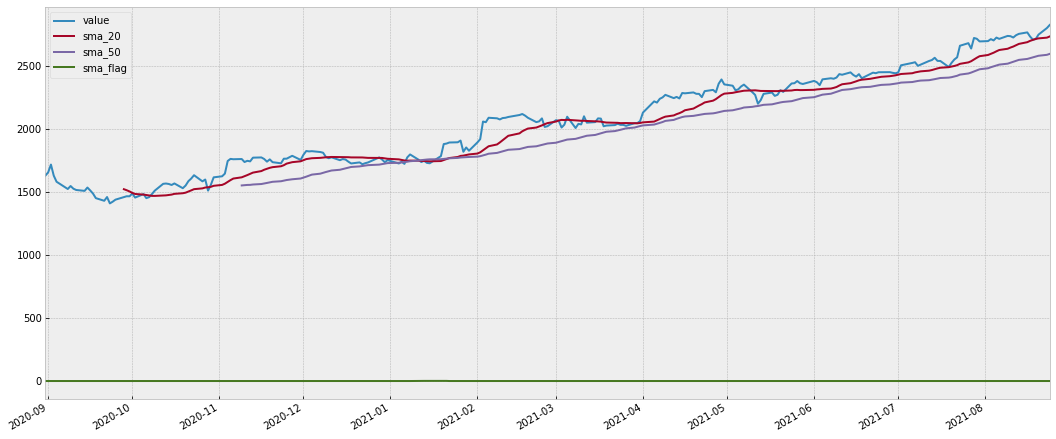

In [45]:
df_aux[df_aux['tick']=='GOOGL'].plot(figsize=(18,8))

Text(0.5, 1.0, 'Stock price evolution')

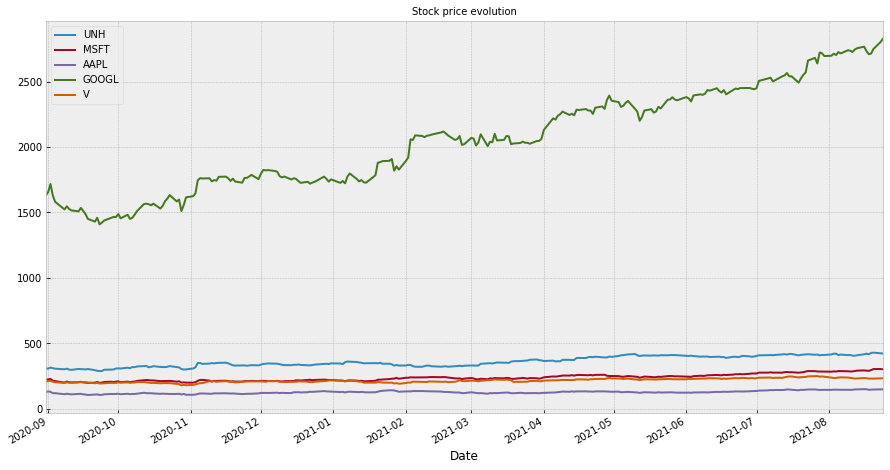

In [46]:
df[ticks].plot(figsize=(15,8))
plt.title("Stock price evolution", size=10)

In [47]:
returns = df.pct_change().dropna()

In [12]:
average_returns = np.sum(returns.mean()*weights)*100
print("Average return base on weights %.2f " % average_returns)

Average return base on weights 0.14 


In [13]:
sp500_return = sp500.pct_change().dropna()
sp500_return = (1 + sp500_return).cumprod()

In [14]:
sp500_return.tail()

,^GSPC
Date,
2020-04-27,1.146791
2020-04-28,1.140779
2020-04-29,1.171106
2020-04-30,1.160317
2020-05-01,1.127759


In [15]:
cumulative_return = df.copy(deep=True)
cumulative_return['PORTAFOLIO'] = returns.dot(weights)
daile_cum_ret = (1 + cumulative_return).cumprod()

Text(0.5, 1.0, 'Portafolio acumulative return')

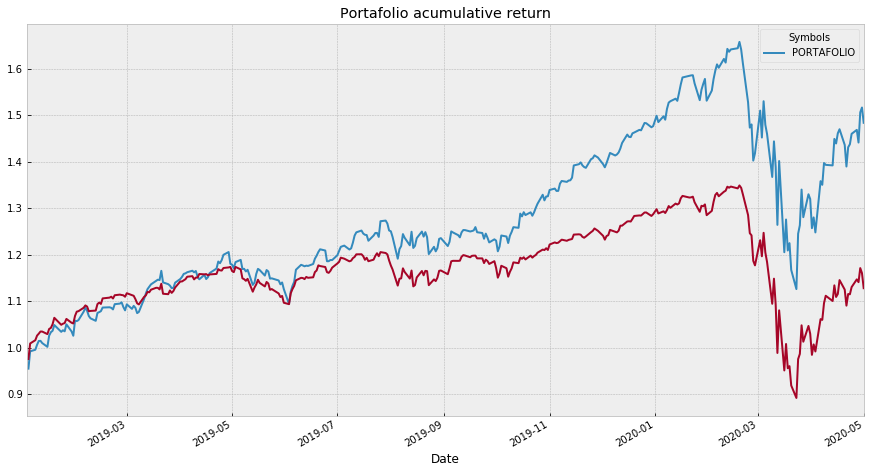

In [16]:
daile_cum_ret[['PORTAFOLIO']].plot(figsize=(15,8))
sp500_return['^GSPC'].plot(figsize=(15,8))
plt.title("Portafolio acumulative return")

In [17]:
(sp500.iloc[-1]/sp500.iloc[0])-1

^GSPC    0.127759
dtype: float64

In [18]:
sp500.iloc[0]

^GSPC    2510.030029
Name: 2019-01-02 00:00:00, dtype: float64

In [19]:
sp500.iloc[-1]

^GSPC    2830.709961
Name: 2020-05-01 00:00:00, dtype: float64

In [20]:
sp500.ialoc[-1]

AttributeError: 'DataFrame' object has no attribute 'ialoc'

In [ ]:
returns[ticks].plot(figsize=(15,8), linewidth=.3)
plt.title("Stock price evolution", size=10)

In [ ]:
for tk in ticks:
    returns[tk].hist(bins=40, figsize=(8,4))
    plt.title(tk + ' Returns distribution', size=10)
    plt.show()

In [26]:
skew_list = []
kurtosis_list = []
shapiro_list = []
annual_vol = []
annual_returns = []
for tk in ticks:
    skewness = np.round(returns[tk].skew(), 3)
    kurt = np.round(returns[tk].kurtosis() + 3, 3)
    shap = np.round(shapiro(returns[tk])[1], 3)
    vol = np.round(returns[tk].std()*np.sqrt(252), 3)
    rtn = np.round((returns[tk].mean()*252), 3)
    
    
    skew_list.append(skewness)
    kurtosis_list.append(kurt)
    shapiro_list.append(shap)
    annual_vol.append(vol)
    annual_returns.append(rtn)

In [27]:
stocks_summary = pd.DataFrame({'STOCK':ticks,
              'SKEW':skew_list,
              'KURTOSIS':kurtosis_list,
              'SHAPIRO':shapiro_list,
              'ANNUAL_VOL':annual_vol,
              'ANNUAL_RETURN':annual_returns})

In [28]:
stocks_summary

,ANNUAL_RETURN,ANNUAL_VOL,KURTOSIS,SHAPIRO,SKEW,STOCK
0,0.225,0.427,12.129,0.0,-0.237,UNH
1,0.490,0.363,14.512,0.0,-0.014,MSFT
2,0.542,0.384,10.259,0.0,-0.265,AAPL
3,0.225,0.341,9.810,0.0,-0.047,GOOGL
4,0.280,0.361,13.909,0.0,0.235,V


In [29]:
# Estudiemos la correlacion
corr_heat = returns.corr()
print(corr_heat)

Symbols      AAPL     GOOGL      MSFT       UNH         V
Symbols                                                  
AAPL     1.000000  0.775420  0.836586  0.626671  0.772143
GOOGL    0.775420  1.000000  0.825541  0.600437  0.759266
MSFT     0.836586  0.825541  1.000000  0.668947  0.832075
UNH      0.626671  0.600437  0.668947  1.000000  0.665629
V        0.772143  0.759266  0.832075  0.665629  1.000000


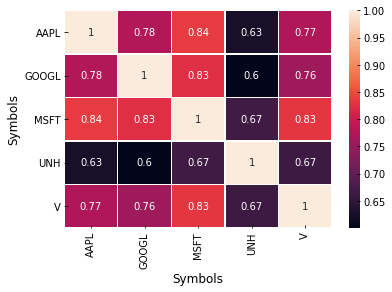

In [30]:
sns.heatmap(corr_heat, annot=True, linewidths=0.4, annot_kws={"size": 10})
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()


In [31]:
# Calculemos ahora la varianza y desviacion estandar (volatilidad) del portafolio
cov_matrix = returns.cov()
print(cov_matrix)
# Si la queremos anualizar
cov_matrix_anual = cov_matrix*252

Symbols      AAPL     GOOGL      MSFT       UNH         V
Symbols                                                  
AAPL     0.000584  0.000402  0.000462  0.000408  0.000424
GOOGL    0.000402  0.000461  0.000405  0.000347  0.000370
MSFT     0.000462  0.000405  0.000522  0.000412  0.000432
UNH      0.000408  0.000347  0.000412  0.000725  0.000407
V        0.000424  0.000370  0.000432  0.000407  0.000517


In [32]:
volatilidad_por_anual = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_anual, weights)))
print("Volatilidad anual del portafolio %.2f" % volatilidad_por_anual)

Volatilidad anual del portafolio 0.33


In [33]:
# Retorno anual del portafolio
portafolio_anual_return = np.sum(returns.mean()*weights)*252
print("Retorno anual del portafolio %.2f" % portafolio_anual_return)

Retorno anual del portafolio 0.35


In [34]:
stocks_summary['ANNUAL_RETURN']

0    0.225
1    0.490
2    0.542
3    0.225
4    0.280
Name: ANNUAL_RETURN, dtype: float64

In [35]:
np.sum(stocks_summary['ANNUAL_RETURN']*weights)

0.3524

In [36]:
tm_start = dt.datetime.today()

In [37]:
tm_end = dt.datetime.today()

In [38]:
(tm_end - tm_start).total_seconds()

0.42075

In [39]:
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

In [40]:
mu = expected_returns.mean_historical_return(df) 
Sigma = risk_models.sample_cov(df)

In [41]:
ef = EfficientFrontier(mu, Sigma)
print (mu, Sigma)

Symbols
AAPL     0.541918
GOOGL    0.225289
MSFT     0.489947
UNH      0.224737
V        0.280174
dtype: float64 Symbols      AAPL     GOOGL      MSFT       UNH         V
Symbols                                                  
AAPL     0.147101  0.101316  0.116426  0.102700  0.106874
GOOGL    0.101316  0.116055  0.102047  0.087402  0.093345
MSFT     0.116426  0.102047  0.131662  0.103716  0.108958
UNH      0.102700  0.087402  0.103716  0.182577  0.102641
V        0.106874  0.093345  0.108958  0.102641  0.130235


In [42]:
raw_weights_maxsharpe = ef.max_sharpe()

In [43]:
cleaned_weights_maxsharpe = ef.clean_weights()
print(cleaned_weights_maxsharpe)

{'AAPL': 0.62536, 'V': 0.0, 'UNH': 0.0, 'GOOGL': 0.0, 'MSFT': 0.37464}


In [44]:
# Show portfolio performance 
ef.portfolio_performance(verbose=True)

Expected annual return: 52.2%
Annual volatility: 36.1%
Sharpe Ratio: 1.39


(0.5224474009311403, 0.361332199544321, 1.3905414506782978)

In [45]:
ef.efficient_return(0.2)
print(ef.clean_weights())
ef.portfolio_performance(verbose=True)

{'AAPL': 0.0, 'V': 0.0, 'UNH': 1.0, 'GOOGL': 0.0, 'MSFT': 0.0}
Expected annual return: 22.5%
Annual volatility: 42.7%
Sharpe Ratio: 0.48


(0.22473657619389745, 0.42729016971085454, 0.4791511499841942)

In [46]:
raw_weights_minvol = ef.min_volatility()
cleaned_weights_minvol = ef.clean_weights()

# Show portfolio performance
print(cleaned_weights_minvol)
ef.portfolio_performance(verbose=True)

{'AAPL': 0.04526, 'V': 0.26242, 'UNH': 0.13558, 'GOOGL': 0.53897, 'MSFT': 0.01777}
Expected annual return: 25.9%
Annual volatility: 32.4%
Sharpe Ratio: 0.74


(0.25865040985403875, 0.32444112625924104, 0.7355738546639979)

In [47]:
raw_weights_maxsharpe = ef.max_sharpe()
cleaned_weights_maxsharpe = ef.clean_weights()
print (cleaned_weights_maxsharpe)
ef.portfolio_performance(verbose=True)

{'AAPL': 0.62536, 'V': 0.0, 'UNH': 0.0, 'GOOGL': 0.0, 'MSFT': 0.37464}
Expected annual return: 52.2%
Annual volatility: 36.1%
Sharpe Ratio: 1.39


(0.5224474009311403, 0.361332199544321, 1.3905414506782978)

In [202]:
isinstance(start_date, dt.date)

True

In [196]:
type(dt.date(2020,1,1))

datetime.date

In [206]:
dt.date.today() - dt.timedelta(2)

datetime.date(2021, 8, 27)

In [217]:
pd.to_datetime('2021-01-01')

Timestamp('2021-01-01 00:00:00')